In [1]:
import numpy as np
# import cv2
import tifffile as tiff
from shapely.geometry import Polygon, mapping, shape, box
from skimage import io
from skimage.measure import label, regionprops
import matplotlib.pyplot as plt
# import json
from rasterio import features
import scanpy as sc
import pandas as pd
import geopandas as gpd

import pickle
import scipy

from ast import literal_eval

import seaborn as sns

from SGanalysis.SGobject import SGobject
from adjustText import adjust_text

import matplotlib
%matplotlib inline
# matplotlib.use('Qt5Agg')
# %matplotlib qt

# import matplotlib as mpl
matplotlib.rcParams['pdf.fonttype'] = 42

from sklearn.cluster import AgglomerativeClustering as AggCluster

%load_ext autoreload
%autoreload 2
%reload_ext autoreload

import sys
import os

# tools_path  = '/Users/grantkinsler/Documents/Penn/Research/SpatialBarcodes/SpatialBarcodes/analysis/tools/tools.py'

tools_path  = '/Users/grantkinsler/Documents/Penn/Research/SpatialBarcodes/analysis/tools/tools.py'

# /Users/grantkinsler/Documents/Penn/Research/SpatialBarcodes/analysis/tools/tools.py
sys.path.append(os.path.dirname(os.path.expanduser(tools_path)))
import tools as tools

In [120]:
n_cells_per_cluster = 25
# clone_scores = pd.read_csv(f'../extractedData/clone_scores_{n_cells_per_cluster}cellspercluster.csv',index_col=0)
clone_scores = pd.read_csv('../extractedData/clone_scores.csv',index_col=0)
clone_scores['p_val_adj'] = clone_scores['p_val']*len(clone_scores.index)

n_rings =  100
space_scores = pd.read_csv(f'../extractedData/space_scores_{n_rings}rings.csv',index_col=0)
space_scores['p_val_adj'] = space_scores['p_val']*len(space_scores.index)


In [121]:
space_scores

,score,p_val,p_val_adj
gene,,,
AKT1,3.056354,0.000084,0.009999
AXL,0.970373,0.463238,55.125368
BGN,1.868584,0.005630,0.669944
BIRC3,1.519481,0.026132,3.109739
BIRC5,3.058432,0.000084,0.009999
...,...,...,...
VGF,1.238216,0.111167,13.228888
WNT5A,0.856266,0.766574,91.222334
YAP1,2.081962,0.000672,0.079993


Number of genes with p-value less than 0.01 and score above 2: 4 total: 119


Text(0, 0.5, 'Ratio of real to permuted delta')

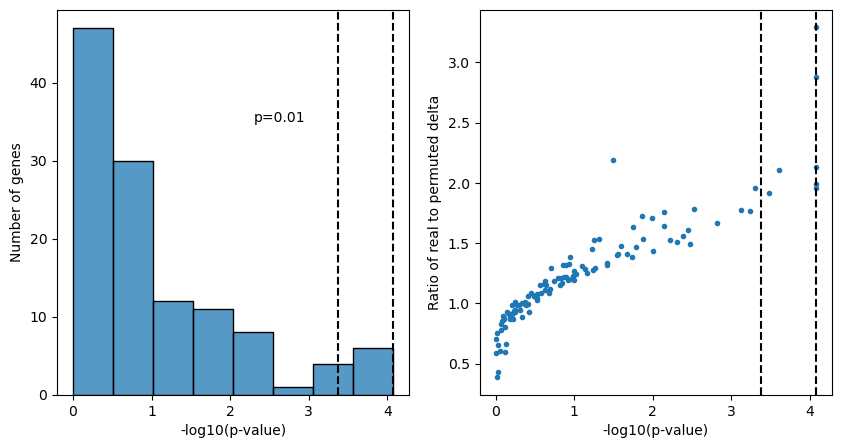

In [122]:
# plot clone scores and p-values]

plt.figure(figsize=(10,5))

## subplot 
plt.subplot(1,2,1)
sns.histplot(-np.log10(clone_scores['p_val']))

plt.axvline(-np.log10(0.01/119),color='k',linestyle='--')
plt.text(-np.log10(0.01/110+0.001),35,'p=0.01',ha='right',color='k')
plt.axvline(-np.log10(0.05/119),color='k',linestyle='--')
# plt.axvline(-np.log10(0.1),color='k',linestyle='--')
plt.xlabel('-log10(p-value)')
plt.ylabel('Number of genes')

# number of genes with p-value less than 0.01 and score above 2
print('Number of genes with p-value less than 0.01 and score above 2:',np.sum((clone_scores['p_val'] < 0.01) & (clone_scores['score'] > 2)),'total:',len(clone_scores.index))
# print()

# calculate ratio of real data to average from the permutations
plt.subplot(1,2,2)
plt.scatter(-np.log10(clone_scores['p_val']),clone_scores['score'],marker='.')

plt.axvline(-np.log10(0.05/len(clone_scores.index)),color='k',linestyle='--')
# plt.text(-np.log10(0.01/110+0.001),35,'p=0.01',ha='right',color='k')
plt.axvline(-np.log10(0.01/len(clone_scores.index)),color='k',linestyle='--')
plt.xlabel('-log10(p-value)')
plt.ylabel('Ratio of real to permuted delta')

# # annotate top genes
# for gene in clone_scores.sort_values('score',ascending=False)[:10].index:
#     plt.text(-np.log10(p_vals[gene]),scores[gene],gene,ha='right')

Number of genes with p-value less than 0.01 and score above 2: 44 total: 119


Text(0, 0.5, 'Ratio of real to permuted delta')

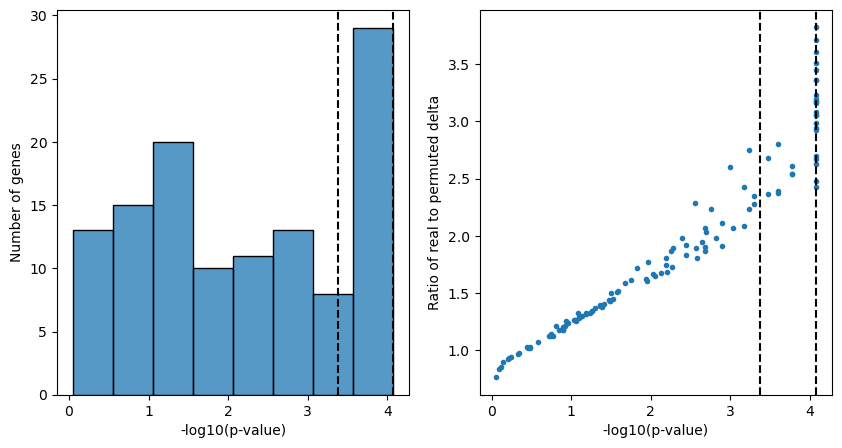

In [123]:
# plot space scores and p-values

plt.figure(figsize=(10,5))

## subplot 
plt.subplot(1,2,1)
sns.histplot(-np.log10(space_scores['p_val']))

plt.axvline(-np.log10(0.01/119),color='k',linestyle='--')
# plt.text(-np.log10(0.01/110+0.001),35,'p=0.01',ha='right',color='k')
plt.axvline(-np.log10(0.05/119),color='k',linestyle='--')
# plt.axvline(-np.log10(0.1),color='k',linestyle='--')
plt.xlabel('-log10(p-value)')
plt.ylabel('Number of genes')

# number of genes with p-value less than 0.01 and score above 2
print('Number of genes with p-value less than 0.01 and score above 2:',np.sum((space_scores['p_val'] < 0.01) & (space_scores['score'] > 2)),'total:',len(space_scores.index))
# print()

# calculate ratio of real data to average from the permutations
plt.subplot(1,2,2)
plt.scatter(-np.log10(space_scores['p_val']),space_scores['score'],marker='.')

plt.axvline(-np.log10(0.05/len(space_scores.index)),color='k',linestyle='--')
# plt.text(-np.log10(0.01/110+0.001),35,'p=0.01',ha='right',color='k')
plt.axvline(-np.log10(0.01/len(space_scores.index)),color='k',linestyle='--')
plt.xlabel('-log10(p-value)')
plt.ylabel('Ratio of real to permuted delta')

# # annotate top genes
# for gene in clone_scores.sort_values('score',ascending=False)[:10].index:
#     plt.text(-np.log10(p_vals[gene]),scores[gene],gene,ha='right')

In [115]:
space_scores[space_scores['p_val_adj'] < 0.01]

,score,p_val,p_val_adj
gene,,,
AKT1,7.298074,0.000084,0.009999
BGN,3.818806,0.000084,0.009999
BIRC5,7.769274,0.000084,0.009999
CALD1,6.164289,0.000084,0.009999
CAPG,7.324999,0.000084,0.009999
...,...,...,...
TYR,7.239119,0.000084,0.009999
VEGFA,8.009587,0.000084,0.009999
YAP1,4.555119,0.000084,0.009999


In [116]:
both_scores = pd.merge(clone_scores,space_scores,left_index=True,right_index=True,suffixes=('_clone','_space'))

In [117]:
both_scores[both_scores['p_val_adj_clone'] < 0.01]

,score_clone,p_val_clone,p_val_adj_clone,score_space,p_val_space,p_val_adj_space
gene,,,,,,
AKT1,2.271922,0.000084,0.009999,7.298074,0.000084,0.009999
CALD1,2.744938,0.000084,0.009999,6.164289,0.000084,0.009999
CAPG,2.174934,0.000084,0.009999,7.324999,0.000084,0.009999
CTNNB1,3.105683,0.000084,0.009999,7.424649,0.000084,0.009999
ESPN,2.113253,0.000084,0.009999,6.947578,0.000084,0.009999
FGFR1,4.000238,0.000084,0.009999,3.584856,0.000084,0.009999
FN1,3.220087,0.000084,0.009999,3.988340,0.000084,0.009999
GFP,2.359665,0.000084,0.009999,3.738658,0.000084,0.009999
HIF1A,2.238623,0.000084,0.009999,6.287611,0.000084,0.009999


([Text(1.5169393406933616, 9.527787669747871, 'VEGFA'),
  Text(6.213012747413885, 2.4825339870327476, 'SFRP1'),
  Text(2.20106628048859, 9.913600749846516, 'MITF'),
  Text(1.2078030987891473, 8.111714173844929, 'SPARC')],
  <matplotlib.patches.FancyArrowPatch at 0x160bf5f10>])

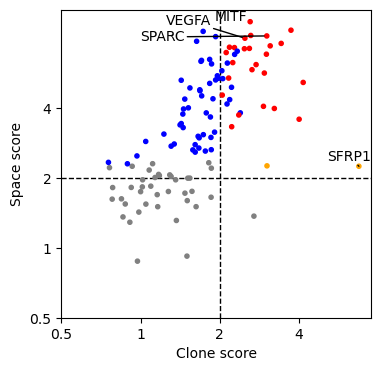

In [119]:
# plot ratio for clone and rings, only plotting genes present in both sets
# common_genes = [gene for gene in scores_ring.index if gene in scores.index]
plt.figure(figsize=(4,4))

color_list = []

score_cutoff = 2 
p_val_adj_cutoff = 0.01

# color points by p-value and score
for entry in both_scores.index:
    if both_scores['score_clone'].loc[entry] > score_cutoff and both_scores['score_space'].loc[entry] > score_cutoff and both_scores['p_val_adj_clone'].loc[entry] < p_val_adj_cutoff and both_scores['p_val_adj_space'].loc[entry] < p_val_adj_cutoff:
        color_list.append('r')
    elif both_scores['score_clone'].loc[entry] > score_cutoff and both_scores['p_val_adj_clone'].loc[entry] < p_val_adj_cutoff:
        color_list.append('orange')
    elif both_scores['p_val_adj_space'].loc[entry] < p_val_adj_cutoff and both_scores['score_space'].loc[entry] > score_cutoff:
        color_list.append('blue')
    else:
        color_list.append('gray')



plt.scatter(both_scores['score_clone'],both_scores['score_space'],marker='.',color=color_list)

plt.xlabel('Clone score\n(ratio of true difference to avg. permuted difference)')
plt.ylabel('Space score\n(ratio of true difference to avg. permuted difference)')

plt.xlabel('Clone score')
plt.ylabel('Space score')

# annotate top 5 genes for each using adjust_text

# genes_to_plot = ['VEGFA','SFRP1','MITF','SPARC','ITGA8','MMP11']
# genes_to_plot = ['VEGFA','SFRP1','MITF','SPARC','MMP1','BMP2']
genes_to_plot = ['VEGFA','SFRP1','MITF','SPARC']


texts = []



for gene in genes_to_plot:
    texts.append(plt.text(both_scores['score_clone'].loc[gene],both_scores['score_space'].loc[gene],gene,ha='right'))

plt.axvline(2,color='k',linestyle='--',lw=1,zorder=0)
plt.axhline(2,color='k',linestyle='--',lw=1,zorder=0) 

# plt.axvline(3,color='k',linestyle='--',lw=1,zorder=0)
# plt.axhline(3,color='k',linestyle='--',lw=1,zorder=0) 

# plt.axvline(1,color='gray',linestyle='-',lw=1,zorder=0)
# plt.axhline(1,color='gray',linestyle='-',lw=1,zorder=0) 

# plt.xlim(0.5,4)
# plt.ylim(0.5,4)

# plt.xlim(0.5,8)
# plt.ylim(0.5,8)
plt.yscale('log',base=2)
plt.xscale('log',base=2)

plt.xticks([0.5,1,2,4],[0.5,1,2,4])
plt.yticks([0.5,1,2,4],[0.5,1,2,4])

# plt.xlim(0,4)
# plt.ylim(0,4)

# plt.xticks([0,1,2,3,4])
# plt.yticks([0,1,2,3,4])


# for gene in scores_ring.sort_values(ascending=False)[:5].index:
#     texts.append(plt.text(scores[gene],scores_ring[gene],gene,ha='right'))

# for gene in scores.sort_values(ascending=False)[:10].index:
#     if gene not in scores_ring.sort_values(ascending=False)[:10].index:
#         texts.append(plt.text(scores[gene],scores_ring[gene],gene,ha='right'))

# for gene in scores.sort_values(ascending=True)[:10].index:
#     if gene in scores_ring.sort_values(ascending=True)[:10].index:
#         if gene != 'ENSMUSG00000071361':
#             texts.append(plt.text(scores[gene],scores_ring[gene],gene,ha='right'))

adjust_text(texts,x=both_scores['score_clone'],y=both_scores['score_space'],force_static=(2,2),arrowprops=dict(arrowstyle='-',color='k'))

# plt.savefig('../graphs/clone_v_space_scores.pdf',bbox_inches='tight',transparent=True)


In [ ]:
### let's plot examples of all of this now.



